In [461]:
import numpy as np
import pandas as pd

import os
import cv2
import matplotlib.pyplot as plt
from PIL import ImageFilter
from PIL import Image

%matplotlib inline

from imgaug import augmenters as iaa
import imgaug as ia
import pytesseract

### Image Processing Tests

In [81]:
#Test code for sample pytesseract text recognition
#Test image in grayscale
img = cv2.imread('./data/test_41.jpg', cv2.IMREAD_GRAYSCALE)

text = pytesseract.image_to_string(img)
print(text)

HAPPY HOUR

wynxm OYSTER $1

n :5: Skin

Hmrwtss r‘ r ‘ a mum
\‘mlmhnw

 

'wupu mum 3

BUTTERBEM HUMWUS
‘Jsmhmmnuum'e mum 9mm \nH.‘|u'mh ;

mupnto sucksmwu mm
panmsan muvc mp s

V‘CTORIAN

«m rnmmuu‘ Lcmuu dnunrv'mlv:mnm 9

HOUSE W‘NF '

<7 ARvHHx WHH

2

half of] ALL 750ml BOTTLES OF
SPARKLING E=- ROSE WINE

700‘ CHESTNUTST SAN FRANChSCO c4


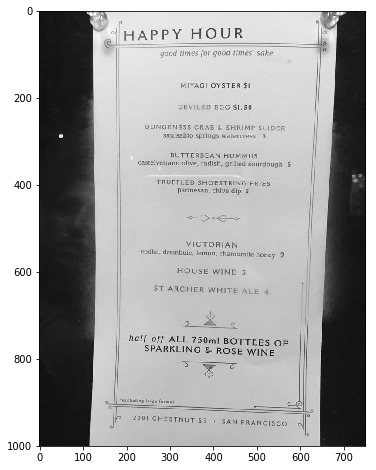

In [18]:
#plotting image to see what grayscale looks like
plt.figure(figsize=(12,8))
plt.imshow(img, cmap='gray')

In [23]:
#Seems to be clearer with sharpened image. Also tried grayscaling sharpened image, but that reduced performance
im1 = Image.open('./data/test_41.jpg')
im1_sharp = im1.filter(ImageFilter.SHARPEN)

text = pytesseract.image_to_string(im1_sharp)
print(text)

im1.close()
im1_sharp.close()

HAPPY HOUR

MWAm OVSTER $1

 

ECG $1,50

DUNGENESS CRAB Cr SHRIMP SL‘DER
Srmlsalim iwlngs mamas» 3

BUTTERBEAN HUMMUS
Lasmlvenanu unve. ladlsh, gunea smmluugh s

TRUFFLED SHOESTRING FRIES
parmesan, mm «11.; 5

V] C TO RI A N
vudkm uxanmuue,1cn\ou. ckmmmmle honev 9

HOUSE WINE 3

ST ARCHER WHH; ‘

 

‘\

W half off ALL 750ml BOTTLES OF H

M SPARKLING t3- ROSE WINE ‘
.37? ﬁg

«8


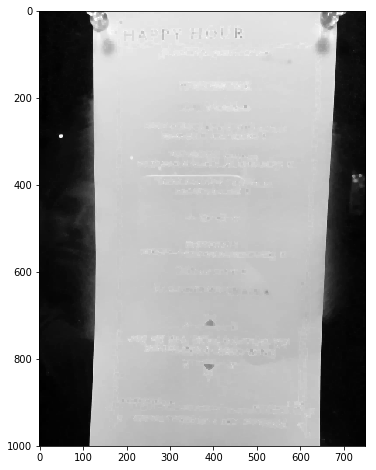

In [20]:
#closing dilates and then errodes an image to effectively close small gaps
kernel = np.ones((5,5),np.uint8)
closing = cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)
plt.figure(figsize=(12,8))
plt.imshow(closing, cmap='gray')


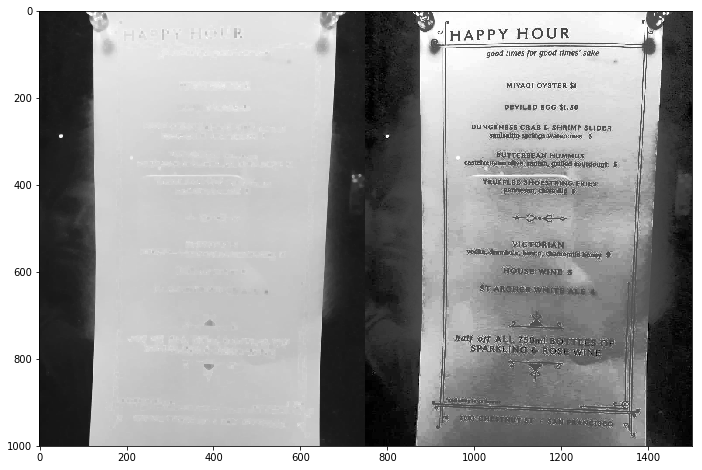

In [30]:
equ = cv2.equalizeHist(img)
res = np.hstack((closing,equ)) #stacking images side-by-side
plt.figure(figsize=(12,8))
plt.imshow(res, cmap='gray')

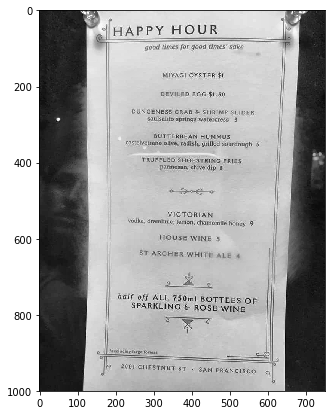

In [29]:
# create a CLAHE object (Arguments are optional).
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
cl1 = clahe.apply(img)

plt.figure(figsize = (12,7))
plt.imshow(cl1, cmap='gray')

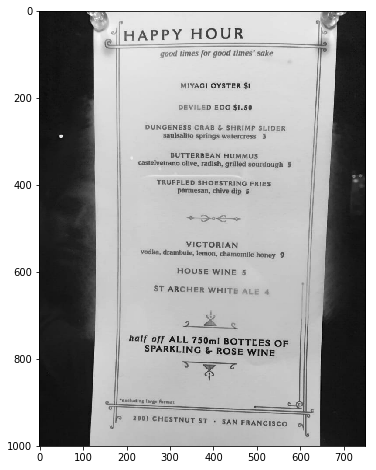

In [41]:
#dilation

kernel= np.ones((2,2),np.uint8)
erosion = cv2.erode(img,kernel,iterations = 1)
plt.figure(figsize=(12,8))
plt.imshow(erosion, cmap='gray')

## Setting up Picture Dataframe

In [462]:
#Creates list of file names in data directory
file_names = os.listdir('data')

In [463]:
#Found a hidden file file_names. Need to remove all hidden files from file_names
'.DS_Store' in file_names

True

In [464]:
#Removes all hidden files from file_list
def sort_and_remove_hidden(file_list):
    #try block to account for error when there are no hidden files in file_list
    try:
        #Sorting will place hidden files at top
        sorted_files = sorted(file_list)
        for i, file in enumerate(sorted_files):
            if file[0] == '.':
                max_period = i
        return sorted_files[max_period+1:]
    
    #returns sorted file_list if no hidden files
    except:
        return sorted(file_list)

In [465]:
#convert file_names
file_names = sort_and_remove_hidden(file_names)

In [466]:
#Loads image, converts to gray scale, resizes, and scales
def convert_image(file_path):
    with Image.open(file_path).convert('L') as image:  #convert('L') makes image grayscale
        resized = image.resize((48, 64))               #resizes image to 64x48
        result = np.array(resized)                     #changes image datatype to numpy array to use reshape
        result = result.reshape(result.shape[0], result.shape[1], 1)    #adds third dimension which corresponds to color channel of 1 for grayscale
        scaled = result / 255                          #scales pixel values from 0 to 1
    return scaled

In [467]:
#Create numpy array for data and targets
target = np.zeros((len(file_names), 1))
data = np.zeros((len(file_names), 64, 48, 1))

#iterate across file names
for i, image_name in enumerate(file_names):
    image = convert_image('./data/' + image_name)
    data[i] = image
    #check file name to derive target. Filesnames containing test and board are images with relevant text
    if ('test' in image_name) or ('board' in image_name):
        #label is 1
        target[i, 0] = 1
        #all other files keep 0 label

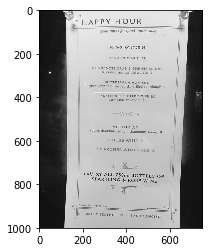

In [469]:
#test image before processing for comparison
plt.imshow(img, cmap='gray')

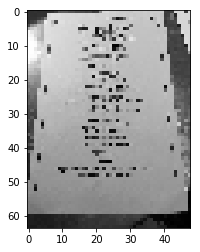

In [470]:
#sample image after preprocessing transformations
test_final_image = data[800,:,:,0]
plt.imshow(test_final_image, cmap='gray')

## Modeling

In [472]:
import tensorflow as tf

from sklearn.datasets import load_boston, load_breast_cancer, load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn import metrics

from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator

#### Splitting Data

In [608]:
X_train, X_test, y_train, y_test = train_test_split(data, target, random_state=5, stratify=target)

#### Neural Network

In [478]:
tf.reset_default_graph()

X = tf.placeholder(dtype=tf.float32, shape=(None, X_train.shape[1], X_train.shape[2], 1), name='X')
y = tf.placeholder(dtype=tf.float32, shape=(None), name='y')

conv1 = tf.layers.conv2d(X, filters=15, kernel_size=[5,5], padding='same', name='conv1', activation=tf.nn.relu)
maxpool1 = tf.layers.max_pooling2d(conv1, pool_size=[2,2], strides=2, name='maxpool1')

conv2 = tf.layers.conv2d(maxpool1, filters=30, kernel_size=[4,4], padding='same', name='conv2', activation=tf.nn.relu)
maxpool2 = tf.layers.max_pooling2d(conv2, pool_size=[2,2], strides=2, name='maxpool2')

#flat = tf.reshape(maxpool2, [-1, int((X_train.shape[1]/4) * (X_train.shape[2]/4) * 10)])
flat = tf.layers.flatten(maxpool2, name='flat')

dense1 = tf.layers.dense(flat, 500, name='dense1', activation=tf.nn.relu)
output = tf.layers.dense(dense1, 1, name='dense2', activation=tf.nn.sigmoid)

loss = tf.losses.log_loss(y, output)

gd = tf.train.AdamOptimizer(learning_rate=.001)
training_op = gd.minimize(loss)



In [32]:
init = tf.global_variables_initializer()

with tf.Session() as sess:
    init.run()
    for epoch in range(20):
        sess.run(training_op, feed_dict={X: X_train, y: y_train})
        training_loss = sess.run(loss, feed_dict={X: X_train, y: y_train})
        test_loss = sess.run(loss, feed_dict={X: X_test, y: y_test})
        print('train loss: ', training_loss, 'test loss: ', test_loss)
    
    pred = sess.run(output, feed_dict={X: X_test})

train loss:  1.068356 test loss:  1.0665361
train loss:  0.70889693 test loss:  0.71561706
train loss:  0.78432995 test loss:  0.7959199
train loss:  0.6513457 test loss:  0.6564568
train loss:  0.6281927 test loss:  0.6296705
train loss:  0.64276505 test loss:  0.6438819
train loss:  0.63284427 test loss:  0.63462317
train loss:  0.6018349 test loss:  0.60492253
train loss:  0.5815371 test loss:  0.5857511
train loss:  0.5855768 test loss:  0.59248513
train loss:  0.57717174 test loss:  0.58568454
train loss:  0.5408823 test loss:  0.54642814
train loss:  0.51699066 test loss:  0.5179876
train loss:  0.50999343 test loss:  0.50834215
train loss:  0.49802288 test loss:  0.49678785
train loss:  0.48307016 test loss:  0.4862521
train loss:  0.4728269 test loss:  0.48042074
train loss:  0.45687768 test loss:  0.46368712
train loss:  0.44486383 test loss:  0.44726017
train loss:  0.43678513 test loss:  0.43906432


In [609]:
#Adding more neurons
tf.reset_default_graph()

X = tf.placeholder(dtype=tf.float32, shape=(None, X_train.shape[1], X_train.shape[2], 1), name='X')
y = tf.placeholder(dtype=tf.float32, shape=(None), name='y')

conv1 = tf.layers.conv2d(X, filters=15, kernel_size=[5,5], padding='same', name='conv1', activation=tf.nn.relu)
maxpool1 = tf.layers.max_pooling2d(conv1, pool_size=[2,2], strides=2, name='maxpool1')

conv2 = tf.layers.conv2d(maxpool1, filters=30, kernel_size=[4,4], padding='same', name='conv2', activation=tf.nn.relu)
maxpool2 = tf.layers.max_pooling2d(conv2, pool_size=[2,2], strides=2, name='maxpool2')

conv3 = tf.layers.conv2d(maxpool2, filters=60, kernel_size=[3,3], padding='same', name='conv3', activation=tf.nn.relu)
maxpool3 = tf.layers.max_pooling2d(conv3, pool_size=[2,2], strides=2, name='maxpool3')

#flat = tf.reshape(maxpool2, [-1, int((X_train.shape[1]/4) * (X_train.shape[2]/4) * 10)])
flat = tf.layers.flatten(maxpool3, name='flat')

dense1 = tf.layers.dense(flat, 1000, name='dense1', activation=tf.nn.relu)
output = tf.layers.dense(dense1, 1, name='dense2', activation=tf.nn.sigmoid)

loss = tf.losses.log_loss(y, output)

gd = tf.train.AdamOptimizer(learning_rate=.0005)
training_op = gd.minimize(loss)

#Starting Session
init = tf.global_variables_initializer()

with tf.Session() as sess:
    init.run()
    for epoch in range(50):
        sess.run(training_op, feed_dict={X: X_train, y: y_train})
        training_loss = sess.run(loss, feed_dict={X: X_train, y: y_train})
        test_loss = sess.run(loss, feed_dict={X: X_test, y: y_test})
        print('train loss: ', training_loss, 'test loss: ', test_loss)
    
    pred = sess.run(output, feed_dict={X: X_test})

train loss:  0.70899147 test loss:  0.71388143
train loss:  0.6636542 test loss:  0.66687673
train loss:  0.6741461 test loss:  0.6760355
train loss:  0.6489421 test loss:  0.6527758
train loss:  0.62555903 test loss:  0.6312844
train loss:  0.60778207 test loss:  0.6149492
train loss:  0.5814562 test loss:  0.5906296
train loss:  0.56456685 test loss:  0.5764382
train loss:  0.53100514 test loss:  0.5462548
train loss:  0.5076944 test loss:  0.52601403
train loss:  0.4823946 test loss:  0.5070623
train loss:  0.4679314 test loss:  0.49966893
train loss:  0.46150887 test loss:  0.4940662
train loss:  0.4442954 test loss:  0.4876051
train loss:  0.43574214 test loss:  0.483123
train loss:  0.43587187 test loss:  0.4815134
train loss:  0.4234698 test loss:  0.47663578
train loss:  0.40993652 test loss:  0.4621127
train loss:  0.40497333 test loss:  0.45459452
train loss:  0.39602724 test loss:  0.44898212
train loss:  0.3812679 test loss:  0.43040866
train loss:  0.37108657 test loss:  0

In [ ]:
#Changing epochs from 30 to 50

In [82]:
pred[:,0]

array([2.96666414e-01, 2.88748771e-01, 7.02164173e-02, 3.67620848e-02,
       1.09891087e-01, 9.94820833e-01, 1.52334850e-02, 9.33047235e-01,
       9.95697498e-01, 9.71251369e-01, 1.11975767e-01, 2.63021775e-02,
       5.40155079e-03, 3.86476852e-02, 3.01540554e-01, 9.92143393e-01,
       1.44802332e-01, 2.46242747e-01, 9.98807311e-01, 9.95655894e-01,
       2.32505873e-01, 1.43613905e-01, 2.32138298e-02, 9.85333622e-01,
       2.88379699e-01, 2.95692772e-01, 1.74453408e-01, 1.94099933e-01,
       3.37459356e-01, 1.61943763e-01, 2.00806275e-01, 9.86246467e-01,
       2.89939456e-02, 9.73546803e-01, 3.30372201e-03, 9.81858373e-01,
       4.05877352e-01, 1.04031496e-01, 2.92973015e-02, 2.71350089e-02,
       3.34778577e-02, 1.15599088e-01, 8.89056563e-01, 9.41250682e-01,
       9.70039189e-01, 4.62713577e-02, 9.59492385e-01, 9.75642025e-01,
       9.92027700e-01, 9.22661006e-01, 3.86047542e-01, 6.73315883e-01,
       2.99499005e-01, 9.94620323e-01, 8.93129036e-02, 1.36480585e-01,
      

In [613]:
#convert prediction probabilities to binary predictions
predictions = (pred[:,0] > 0.5).astype(int)
metrics.accuracy_score(y_test, predictions)

0.9185393258426966

In [614]:
metrics.confusion_matrix(y_test[:,0], predictions).ravel()

array([155,   7,  22, 172])

In [615]:
#Confusion matrix
tn, fp, fn, tp = metrics.confusion_matrix(y_test[:,0], predictions).ravel()

In [616]:
(tn + tp) / (tn+fp+fn+tp)

0.9185393258426966

In [77]:
#Accuracy score
(tn + tp) / (tn+fp+fn+tp)

0.8567415730337079

#### Augmenting Data

In [624]:
#Applies a handful of image transformations to diversify dataset

#Increased inversion from 0.1 to 0.4

sometimes = lambda aug: iaa.Sometimes(0.6, aug) #applies given augmenter 50% of the time

seq = iaa.Sequential([
    iaa.Fliplr(0.6), #flipped horizontally 50% of the time
    iaa.Flipud(0.2), 
    sometimes(iaa.CropAndPad(
            percent=(-0.05, 0.1),
            pad_mode=ia.ALL,)),
    sometimes(iaa.Affine(
            scale={"x": (0.8, 1.2), "y": (0.8, 1.2)}, # scale images to 80-120% of their size, individually per axis
            translate_percent={"x": (-0.25, 0.25), "y": (-0.2, 0.2)}, # translate by -20 to +20 percent (per axis)
            rotate=(-45, 45))), # rotate by -45 to +45 degrees
    sometimes(iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5))), #sharpen images
    iaa.Invert(0.4) # invert color channels
], random_order=True
)

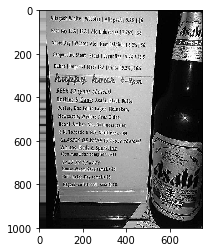

In [796]:
#Test transformation
#Can rerun cell to see random image transformations in effect
images_aug = seq.augment_images(img.reshape(1,1000,750,1))
plt.imshow(images_aug[0,:,:,0], cmap='gray')

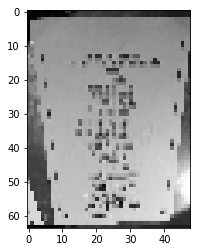

In [471]:
#test call on one of the scaled images
#Seems that augment_images does not work on scaled images.
#For images that have already been scaled, pixel values must be multiplied by 255 when passed to augment images.
#Output is rescaled
images_aug_test = seq.augment_images(test_final_image.reshape(1,64,48,1) * 255) / 255
plt.imshow(images_aug_test[0,:,:,0], cmap='gray')

In [625]:
#Augmented data from X_train
augmented_data = (seq.augment_images(X_train * 255) / 255)

In [626]:
#Concatenating augmented_data to X_train
X_train = np.concatenate((X_train, augmented_data), axis=0)

In [627]:
#y_train needs to be duplicated to match augmented X_train
y_train = np.concatenate((y_train, y_train), axis=0)

In [628]:
#Rerunning best performing neural network with data augmentation
tf.reset_default_graph()

X = tf.placeholder(dtype=tf.float32, shape=(None, X_train.shape[1], X_train.shape[2], 1), name='X')
y = tf.placeholder(dtype=tf.float32, shape=(None), name='y')

conv1 = tf.layers.conv2d(X, filters=15, kernel_size=[5,5], padding='same', name='conv1', activation=tf.nn.relu)
maxpool1 = tf.layers.max_pooling2d(conv1, pool_size=[2,2], strides=2, name='maxpool1')

conv2 = tf.layers.conv2d(maxpool1, filters=30, kernel_size=[4,4], padding='same', name='conv2', activation=tf.nn.relu)
maxpool2 = tf.layers.max_pooling2d(conv2, pool_size=[2,2], strides=2, name='maxpool2')

conv3 = tf.layers.conv2d(maxpool2, filters=60, kernel_size=[3,3], padding='same', name='conv3', activation=tf.nn.relu)
maxpool3 = tf.layers.max_pooling2d(conv3, pool_size=[2,2], strides=2, name='maxpool3')

flat = tf.layers.flatten(maxpool3, name='flat')

dense1 = tf.layers.dense(flat, 1000, name='dense1', activation=tf.nn.relu)
output = tf.layers.dense(dense1, 1, name='dense2', activation=tf.nn.sigmoid)

loss = tf.losses.log_loss(y, output)

gd = tf.train.AdamOptimizer(learning_rate=.0005)
training_op = gd.minimize(loss)

saver = tf.train.Saver()

#Starting Session
init = tf.global_variables_initializer()

with tf.Session() as sess:
    init.run()
    for epoch in range(50):
        sess.run(training_op, feed_dict={X: X_train, y: y_train})
        training_loss = sess.run(loss, feed_dict={X: X_train, y: y_train})
        test_loss = sess.run(loss, feed_dict={X: X_test, y: y_test})
        print('train loss: ', training_loss, 'test loss: ', test_loss)
    
    saver.save(sess, './models/menu_classifier.ckpt')
    pred = sess.run(output, feed_dict={X: X_test})

train loss:  0.8522491 test loss:  0.8096732
train loss:  0.6680622 test loss:  0.6594979
train loss:  0.75167036 test loss:  0.72583383
train loss:  0.7001147 test loss:  0.6829995
train loss:  0.66422075 test loss:  0.6544859
train loss:  0.6628864 test loss:  0.65351224
train loss:  0.67052275 test loss:  0.6594407
train loss:  0.6725443 test loss:  0.66081005
train loss:  0.666975 test loss:  0.65590274
train loss:  0.65839046 test loss:  0.6480186
train loss:  0.6535949 test loss:  0.6427479
train loss:  0.65213585 test loss:  0.6383755
train loss:  0.64546335 test loss:  0.62746006
train loss:  0.6328924 test loss:  0.61070275
train loss:  0.6195328 test loss:  0.5936808
train loss:  0.608387 test loss:  0.57914925
train loss:  0.59936386 test loss:  0.56688946
train loss:  0.5912875 test loss:  0.55457175
train loss:  0.5823996 test loss:  0.54143715
train loss:  0.57275873 test loss:  0.52826744
train loss:  0.56263775 test loss:  0.5129537
train loss:  0.5524451 test loss:  0.

In [632]:
#Score after augmenting data
#Insignificant change
predictions = (pred[:,0] > 0.5).astype(int)

print(metrics.confusion_matrix(y_test[:,0], predictions).ravel())
tn, fp, fn, tp = metrics.confusion_matrix(y_test[:,0], predictions).ravel()

print((tn + tp) / (tn+fp+fn+tp))

print(metrics.accuracy_score(y_test, predictions))

[147  15  35 159]
0.8595505617977528
0.8595505617977528


### Testing downstream workflow for errors on training data

In [633]:
test_file_names = os.listdir('./data')
test_file_names = remove_hidden(test_file_names)
test_images = np.zeros((len(test_file_names), 64, 48, 1))

#iterate across file names
for i, image_name in enumerate(test_file_names):
    image = convert_image('./data/' + image_name)
    test_images[i] = image
                             
#Getting predictions

with tf.Session() as sess:
    saver.restore(sess, './models/menu_classifier.ckpt')
    test_pred = sess.run(output, feed_dict={X: test_images})

INFO:tensorflow:Restoring parameters from ./models/menu_classifier.ckpt


In [634]:
test_pred_classes = (test_pred[:,0] > 0.5).astype(int)
menu_indexes = [i for i, img_class in enumerate(test_pred_classes) if img_class == 1]

In [786]:
import Levenshtein
from sklearn.feature_extraction.text import CountVectorizer

#Dictionary of text from positively classified images.
#Index is the name of the image, value is text found in the image
text_from_images = {}

for menu_index in menu_indexes:
    img = cv2.imread('./data/{}'.format(test_file_names[menu_index]), cv2.IMREAD_GRAYSCALE)
    text = pytesseract.image_to_string(img)
    
    #Images from which pytesseract does not find text returns an empty strings.
    #Cannot pass an empty string or one gram to CountVectorizer. Therefore, do not store text for empty strings
    #or strings without spaces
    if (text == '') or (' ' not in text):
        continue
    else:
        text_from_images[menu_index] = text
    

In [718]:
# #testing on one image
# cvec = CountVectorizer(strip_accents='ascii', ngram_range=(2,2), stop_words='english')

# scores = {}

# cvec.fit([text_from_images[10]]) #sample image in which text was found
# word_pairs = cvec.get_feature_names()
# list_scores = []
# for pair in word_pairs:
#     list_scores.append(Levenshtein.ratio(pair, 'happy hour'))
# scores[10] = max(list_scores)

In [797]:
#count vectorizer model that removes accents, removes stop words, and produces two grams from text
cvec = CountVectorizer(lowercase=True, strip_accents='ascii', ngram_range=(2,2), stop_words='english')

#Dictionary of Levenshtein ratio scores with key corresponding to image number and value containing max similarity ratio
scores = {}

#Iterates through text of every image
for image, text in text_from_images.items():
    cvec.fit([text])
    #gets word pairs from count vectorizer model, counts are not needed
    word_pairs = cvec.get_feature_names()
    
    #Iterates through all 2 grams and compares to string happy hour
    list_scores = []
    for pair in word_pairs:
        list_scores.append(Levenshtein.ratio(pair, 'happy hour'))
    #store highest score from word pairs in scores
    scores[image] = max(list_scores)

In [799]:
#verifying scores is expected structure
scores

{10: 1.0,
 11: 0.25,
 27: 0.9473684210526315,
 37: 0.42105263157894735,
 38: 0.47619047619047616,
 45: 0.3,
 51: 0.3,
 58: 0.26666666666666666,
 62: 0.5,
 69: 0.35294117647058826,
 73: 0.3333333333333333,
 81: 1.0,
 93: 1.0,
 746: 0.34782608695652173,
 747: 0.9,
 748: 0.47619047619047616,
 749: 1.0,
 750: 1.0,
 751: 0.6,
 752: 1.0,
 753: 0.5263157894736842,
 755: 1.0,
 756: 1.0,
 757: 1.0,
 758: 1.0,
 759: 1.0,
 761: 0.9473684210526315,
 762: 1.0,
 763: 1.0,
 764: 1.0,
 765: 1.0,
 766: 1.0,
 768: 1.0,
 769: 1.0,
 770: 0.9473684210526315,
 771: 1.0,
 772: 0.47619047619047616,
 774: 0.45454545454545453,
 775: 0.9,
 776: 1.0,
 777: 1.0,
 778: 1.0,
 779: 0.26666666666666666,
 780: 0.8571428571428571,
 781: 1.0,
 782: 0.6363636363636364,
 783: 0.3157894736842105,
 785: 1.0,
 786: 1.0,
 787: 1.0,
 788: 0.47058823529411764,
 789: 1.0,
 790: 0.5,
 791: 1.0,
 793: 1.0,
 795: 0.75,
 796: 0.375,
 797: 0.7368421052631579,
 798: 0.7,
 799: 0.5,
 800: 0.8235294117647058,
 803: 0.2857142857142857,
 8

## Predictions on Unseen Data

In [ ]:
#Untested code below, needs rewriting based on working test code above

In [485]:
#Creates list of file names in data directory
test_file_names = os.listdir('./images')
test_file_names = sorted(test_file_names)
test_images = np.zeros((len(test_file_names), 64, 48, 1))

#iterate across file names
for i, image_name in enumerate(test_file_names):
    image = convert_image('./images/' + image_name)
    test_images[i] = image
                             
#Getting predictions
init = tf.global_variables_initializer()

with tf.Session() as sess:
    init.run()
    test_pred = sess.run(output, feed_dict={X: test_images})

AttributeError: module 'PIL.Image' has no attribute 'register_extensions'

In [ ]:
#Prediction proportion to class predictions
predictions = (test_pred[:,0] > 0.5).astype(int)

menu_indexes = [i for i, img_class in enumerate(predictions) if img_class == 1]

In [539]:
import Levenshtein
from sklearn.feature_extraction.text import CountVectorizer
from collections import defaultdict

#Dictionary of text from positively classified images.
#Index is the name of the image, value is text found in the image
text_from_images = defaultdict(list)

for menu_index in menu_indexes:
    img = cv2.imread('./data/{}'.format(test_file_names[menu_index]), cv2.IMREAD_GRAYSCALE)
    text = pytesseract.image_to_string(img)
    text_from_images[menu_index] = text

In [523]:
#count vectorizer model that removes accents, removes stop words, and produces two grams from text
cvec = CountVectorizer(strip_accents='ascii', ngram_range=(2,2), stop_words='english')

#Dictionary of Levenshtein ratio scores with key corresponding to image number and value containing max similarity ratio
scores = {}

#Iterates through text of every image
for image, text from text_from_images.items:
    cvec.fit(text)
    #gets word pairs from count vectorizer model
    word_pairs = cvec.get_feature_names()
    
    #Iterates through all 2 grams and compares to several variations of happy hour.
    #Highest similarity ratio is stored in scores
    for pair in word_pairs:
        list_scores = []
        list_scores.append(Levenshtein.ratio(pair, 'happy hour'))
        list_scores.append(Levenshtein.ratio(pair, 'HAPPY HOUR'))
        list_scores.append(Levenshtein.ratio(pair, 'Happy hour'))
        list_scores.append(Levenshtein.ratio(pair, 'happy Hour'))
        scores[image] = max(list_scores)


1.0

In [520]:
file = './data/test_50.jpg'

test_image_processing = cv2.imread('./data/test_50.jpg', cv2.IMREAD_GRAYSCALE)

test_text_processing = pytesseract.image_to_string(test_image_processing)

In [521]:
test_text_processing

'$6 HAPPY HOUR\n\nSGWELLDRIMKS\nMme spun- soda, Imlc or amberry'

In [559]:
scores = defaultdict(list)
i=0
for pairs in word_pairs:
    scores[i].append(Levenshtein.ratio(pairs, 'happy hour'))
    scores[i].append(Levenshtein.ratio(pairs, 'HAPPY HOUR'))
    scores[i].append(Levenshtein.ratio(pairs, 'Happy hour'))
    scores[i].append(Levenshtein.ratio(pairs, 'happy Hour'))
    

max(scores[0])

1.0

In [771]:
Levenshtein.ratio('clve4lwww2 clve4lwww2', 'happy hour')

0.06451612903225806

## THINGS TO IMPLEMENT

In [ ]:
#deeper investigation into which images are incorrectly classified. Try looking at some to see what they are,
#look at histograms to see if there is a pattern in pixel intensity

#Additional parameter tuning of neural network to see if results are improved

#Consider reducing probability considered a positive prediction.
#It is less important for me to incorrectly identify non-menu images as menu images as I have redundancy control with pytesseract.

#Revise text recognition step to be performed on color/grayscale sharpened images and compare the results.
#Saw increased text recognition on one sample test, this may or may not hold for others.
#Based on comparison, I will either choose the better performing recognition (between grayscale/sharpened/color)
#or perform multiple steps of text recognition to better capture images that produce better results from different image processing steps

#Consider other similar phrases to happy hour to compare text against. Determine a threshold value for Levenshtein that most likely contains happy hour.

#Test neural network and test recognition on actual test data rather than train data.

